In [1]:
from google.colab import drive
drive.mount("/content/gdrive",force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [11]:
mkdir dataset

dataset/


# Data - Mnist

In [0]:
import os
os.chdir("/root/dataset")
import numpy as np

In [0]:
from IPython import display



import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

In [0]:
# Image processing
def mnist_data():
    compose = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5,), 
                                     std=(0.5,))])
    return datasets.MNIST(root='/root/dataset', train=True, transform=compose, download=True)


In [0]:
batch_size = 100
# Load data
data = mnist_data()

# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

# Num batches
num_batches = len(data_loader)


# Network

In [0]:
class Discriminator(torch.nn.Module):
    '''
    3 hidden layer discriminative neural network 
    '''
    def __init__(self):
        super(Discriminator,self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden_0 = nn.Sequential(
                        nn.Linear(n_features,1024),
                        nn.LeakyReLU(0.2),
                        nn.Dropout(0.3)
        )
        self.hidden_1 = nn.Sequential(
                        nn.Linear(1024,512),
                        nn.LeakyReLU(0.2),
                        nn.Dropout(0.3)
        )
        self.hidden_2 = nn.Sequential(
                        nn.Linear(512,256),
                        nn.LeakyReLU(0.2),
                        nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
                        nn.Linear(256,n_out),
                        nn.Sigmoid()
        )
    
    def forward(self,x):
        x = self.hidden_0(x)
        x = self.hidden_1(x)
        x = self.hidden_2(x)
        x = self.out(x)
        return x
    
D = Discriminator()    

In [0]:
class Generator(torch.nn.Module):
    '''
    3 hidden layer generative network
    '''
    def __init__(self):
        super(Generator,self).__init__()
        n_latent = 100
        n_out = 784
        
        self.hidden_0 = nn.Sequential(
                        nn.Linear(n_latent,256),
                        nn.LeakyReLU(0.2)
        )
        self.hidden_1 = nn.Sequential(
                        nn.Linear(256,512),
                        nn.LeakyReLU(0.2)
        )
        self.hidden_2 = nn.Sequential(
                        nn.Linear(512,1024),
                        nn.LeakyReLU(0.2)
        )
        self.out = nn.Sequential(
                        nn.Linear(1024,784),
                        nn.Tanh()
        )
        
    def forward(self,x):
        x = self.hidden_0(x)
        x = self.hidden_1(x)
        x = self.hidden_2(x)
        x = self.out(x)
        return x
G = Generator()    

# Loss & Optimization

- Binary CE LOSS

- Adam as the optimization algorithm for both neural networks, with a learning rate of 0.0002. 

- betas=(0.5, 0.999)

In [0]:
# Binary cross entropy loss and optimizer
loss = nn.BCELoss()

D_optimizer = optim.Adam(D.parameters(), lr=0.0002,betas=(0.5, 0.999))
G_optimizer = optim.Adam(G.parameters(), lr=0.0002,betas=(0.5, 0.999))

# Traning

In [0]:
def images_to_vectors(images):
    return images.reshape(images.size(0),-1)

def vectors_to_images(vectors):
    return vectors.reshape(vectors.size(0),1,28,28)

def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    return n


In [0]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = D(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = D(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [0]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = D(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [0]:
num_test_samples = 16
test_noise = noise(num_test_samples)

# logger for visualization

In [54]:
"""utils.py

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1kQZ1iuvC0sDbmN7JIJZjm5R_sqtBlCXa
"""
!pip install tensorboardx
import numpy as np
import errno
import torchvision.utils as vutils
from tensorboardX import SummaryWriter
from IPython import display
from matplotlib import pyplot as plt
import torch

'''
    TensorBoard Data will be stored in './runs' path
'''


class Logger:

    def __init__(self, model_name, data_name):
        self.model_name = model_name
        self.data_name = data_name

        self.comment = '{}_{}'.format(model_name, data_name)
        self.data_subdir = '{}/{}'.format(model_name, data_name)

        # TensorBoard
        self.writer = SummaryWriter(comment=self.comment)

    def log(self, d_error, g_error, epoch, n_batch, num_batches):

        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()

        step = Logger._step(epoch, n_batch, num_batches)
        self.writer.add_scalar(
            '{}/D_error'.format(self.comment), d_error, step)
        self.writer.add_scalar(
            '{}/G_error'.format(self.comment), g_error, step)

    def log_images(self, images, num_images, epoch, n_batch, num_batches, format='NCHW', normalize=True):
        '''
        input images are expected in format (NCHW)
        '''
        if type(images) == np.ndarray:
            images = torch.from_numpy(images)
        
        if format=='NHWC':
            images = images.transpose(1,3)
        

        step = Logger._step(epoch, n_batch, num_batches)
        img_name = '{}/images{}'.format(self.comment, '')

        # Make horizontal grid from image tensor
        horizontal_grid = vutils.make_grid(
            images, normalize=normalize, scale_each=True)
        # Make vertical grid from image tensor
        nrows = int(np.sqrt(num_images))
        grid = vutils.make_grid(
            images, nrow=nrows, normalize=True, scale_each=True)

        # Add horizontal images to tensorboard
        self.writer.add_image(img_name, horizontal_grid, step)

        # Save plots
        self.save_torch_images(horizontal_grid, grid, epoch, n_batch)

    def save_torch_images(self, horizontal_grid, grid, epoch, n_batch, plot_horizontal=True):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)

        # Plot and save horizontal
        fig = plt.figure(figsize=(16, 16))
        plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
        plt.axis('off')
        if plot_horizontal:
            display.display(plt.gcf())
        self._save_images(fig, epoch, n_batch, 'hori')
        plt.close()

        # Save squared
        fig = plt.figure()
        plt.imshow(np.moveaxis(grid.numpy(), 0, -1))
        plt.axis('off')
        self._save_images(fig, epoch, n_batch)
        plt.close()

    def _save_images(self, fig, epoch, n_batch, comment=''):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir,
                                                         comment, epoch, n_batch))

    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake):
        
        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()
        if isinstance(d_pred_real, torch.autograd.Variable):
            d_pred_real = d_pred_real.data
        if isinstance(d_pred_fake, torch.autograd.Variable):
            d_pred_fake = d_pred_fake.data
        
        
        print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
            epoch,num_epochs, n_batch, num_batches)
             )
        print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
        print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))

    def save_models(self, generator, discriminator, epoch):
        out_dir = './data/models/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        torch.save(generator.state_dict(),
                   '{}/G_epoch_{}'.format(out_dir, epoch))
        torch.save(discriminator.state_dict(),
                   '{}/D_epoch_{}'.format(out_dir, epoch))

    def close(self):
        self.writer.close()

    # Private Functionality

    @staticmethod
    def _step(epoch, n_batch, num_batches):
        return epoch * num_batches + n_batch

    @staticmethod
    def _make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

     |████████████████████████████████| 133kB 5.8MB/s 


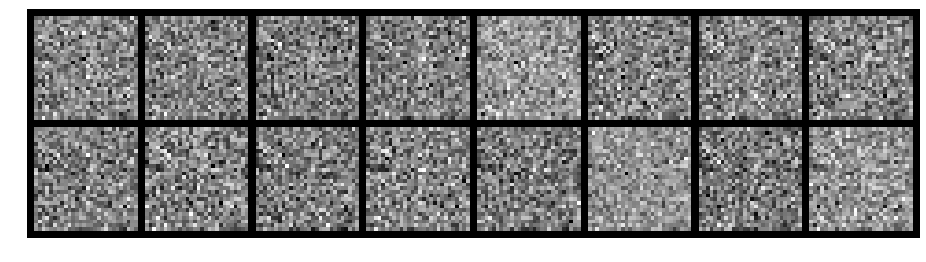

Epoch: [0/200], Batch Num: [0/600]
Discriminator Loss: 1.3512, Generator Loss: 0.7127
D(x): 0.5084, D(G(z)): 0.4905


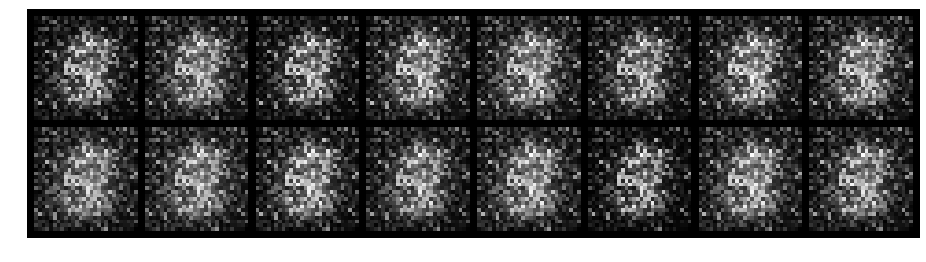

Epoch: [0/200], Batch Num: [100/600]
Discriminator Loss: 1.3512, Generator Loss: 0.7958
D(x): 0.5786, D(G(z)): 0.5432


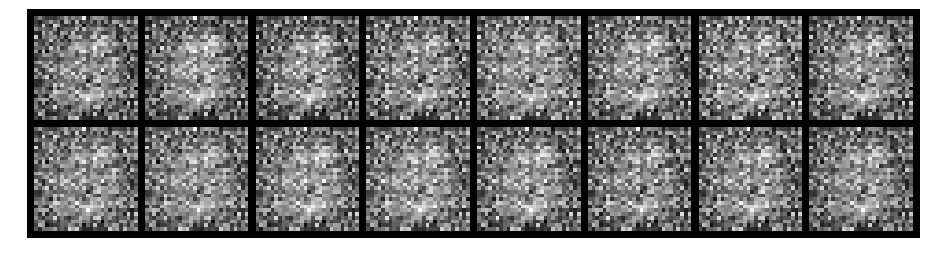

Epoch: [0/200], Batch Num: [200/600]
Discriminator Loss: 0.7333, Generator Loss: 1.8929
D(x): 0.9352, D(G(z)): 0.4741


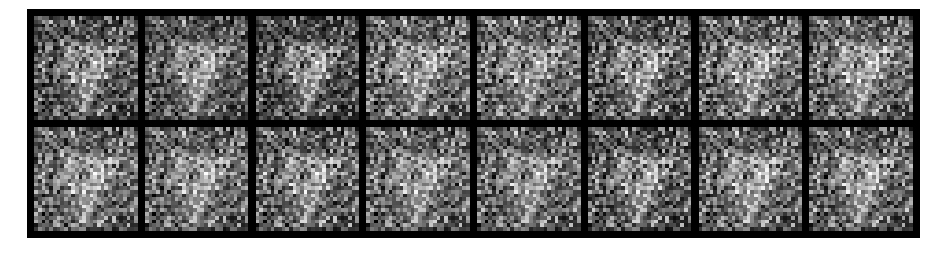

Epoch: [0/200], Batch Num: [300/600]
Discriminator Loss: 0.3043, Generator Loss: 3.2384
D(x): 0.9817, D(G(z)): 0.2374


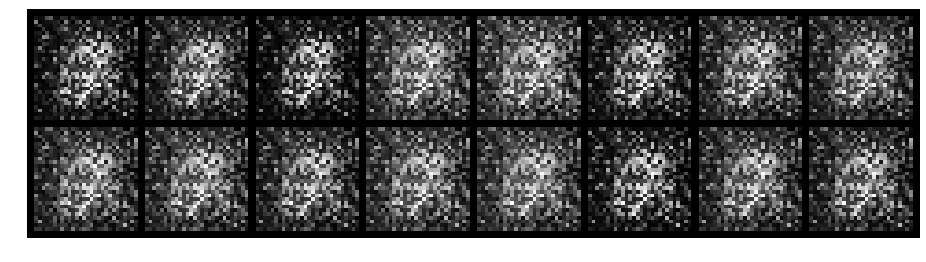

Epoch: [0/200], Batch Num: [400/600]
Discriminator Loss: 0.4042, Generator Loss: 3.5276
D(x): 0.7768, D(G(z)): 0.0524


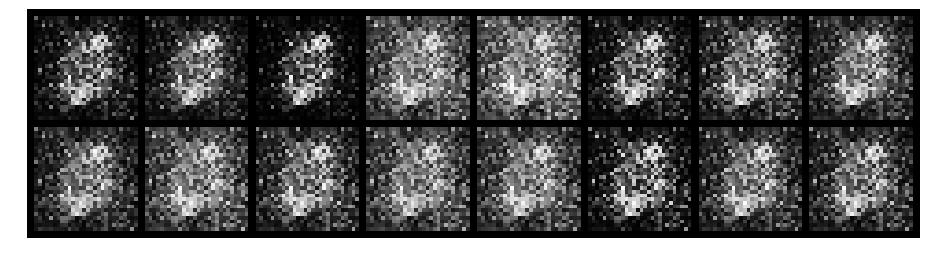

Epoch: [0/200], Batch Num: [500/600]
Discriminator Loss: 0.4057, Generator Loss: 3.3147
D(x): 0.8356, D(G(z)): 0.0687


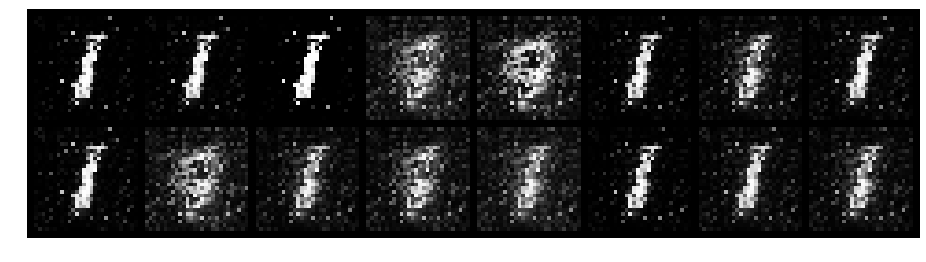

Epoch: [1/200], Batch Num: [0/600]
Discriminator Loss: 0.3410, Generator Loss: 1.8301
D(x): 0.8585, D(G(z)): 0.0968


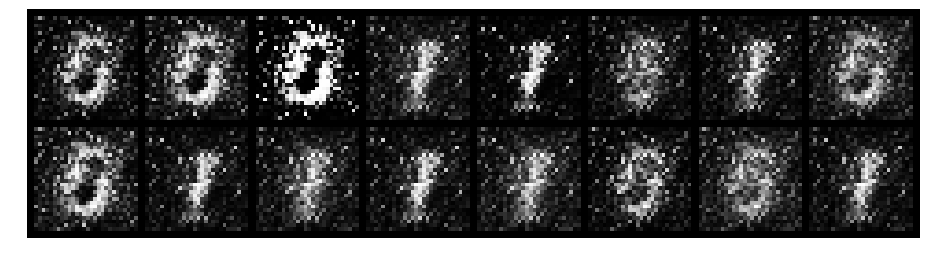

Epoch: [1/200], Batch Num: [100/600]
Discriminator Loss: 0.5622, Generator Loss: 2.5740
D(x): 0.9516, D(G(z)): 0.3062


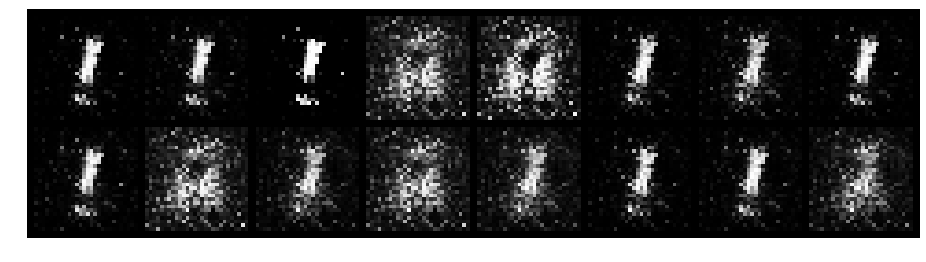

Epoch: [1/200], Batch Num: [200/600]
Discriminator Loss: 0.3546, Generator Loss: 2.6067
D(x): 0.8663, D(G(z)): 0.1364


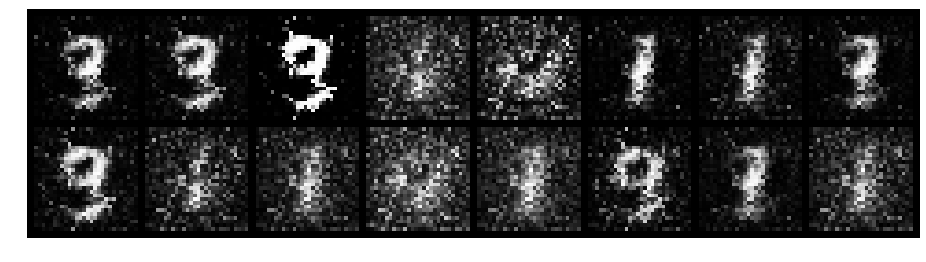

Epoch: [1/200], Batch Num: [300/600]
Discriminator Loss: 0.6423, Generator Loss: 1.3174
D(x): 0.7286, D(G(z)): 0.1284


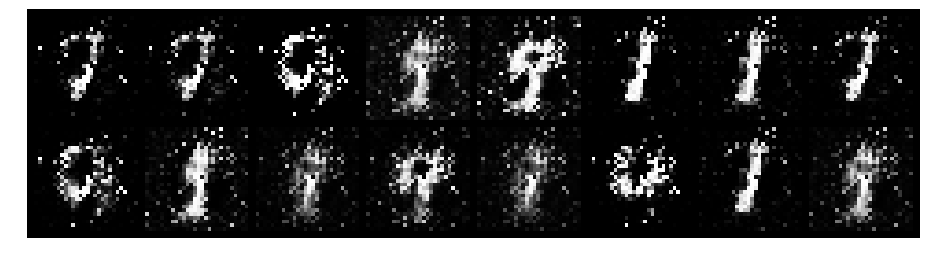

Epoch: [1/200], Batch Num: [400/600]
Discriminator Loss: 0.2722, Generator Loss: 4.4039
D(x): 0.9339, D(G(z)): 0.1539


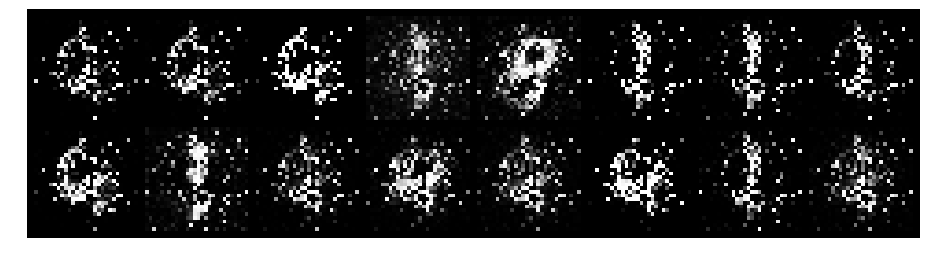

Epoch: [1/200], Batch Num: [500/600]
Discriminator Loss: 0.3935, Generator Loss: 2.4662
D(x): 0.8432, D(G(z)): 0.0176


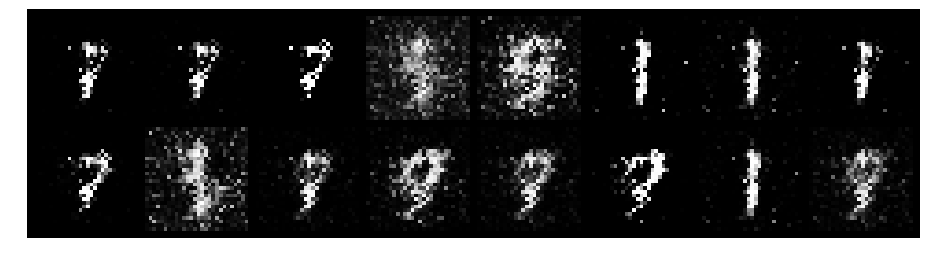

Epoch: [2/200], Batch Num: [0/600]
Discriminator Loss: 0.2260, Generator Loss: 2.5341
D(x): 0.9459, D(G(z)): 0.1382


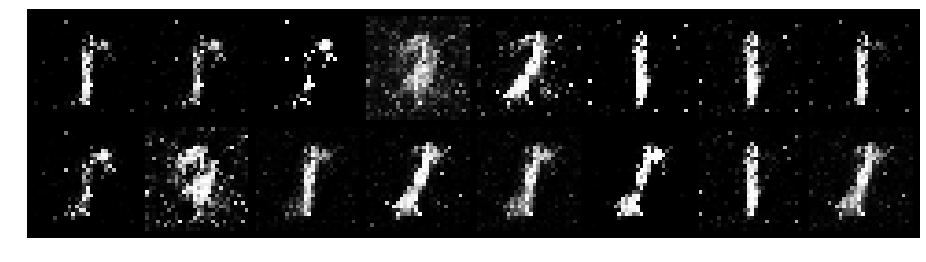

Epoch: [2/200], Batch Num: [100/600]
Discriminator Loss: 0.2537, Generator Loss: 2.8703
D(x): 0.9123, D(G(z)): 0.0758


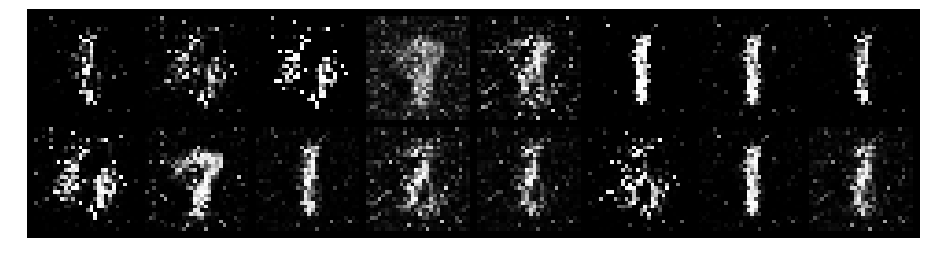

Epoch: [2/200], Batch Num: [200/600]
Discriminator Loss: 0.4811, Generator Loss: 2.8109
D(x): 0.9079, D(G(z)): 0.2370


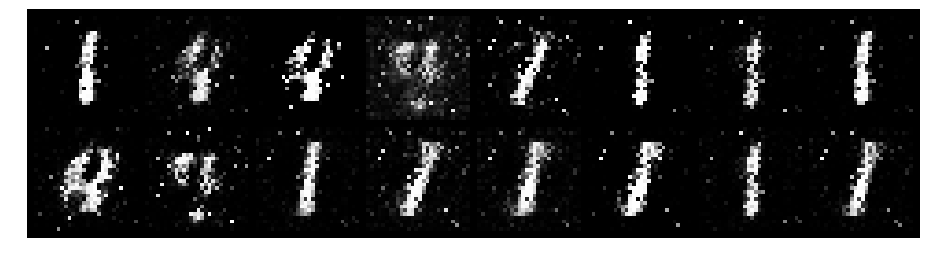

Epoch: [2/200], Batch Num: [300/600]
Discriminator Loss: 0.4472, Generator Loss: 1.8552
D(x): 0.7788, D(G(z)): 0.0431


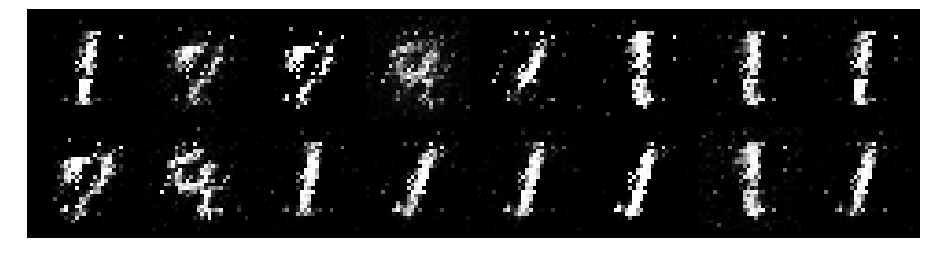

Epoch: [2/200], Batch Num: [400/600]
Discriminator Loss: 0.4970, Generator Loss: 1.5253
D(x): 0.7784, D(G(z)): 0.0764


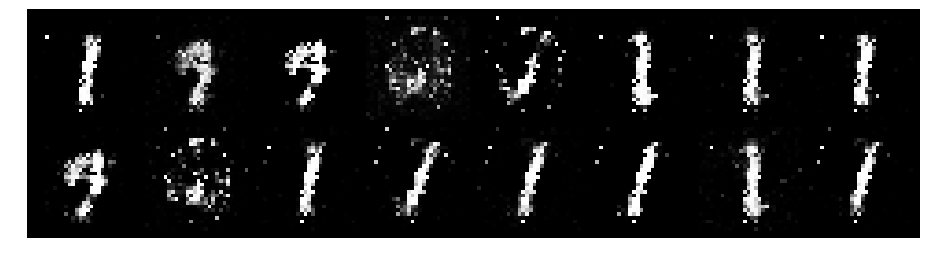

Epoch: [2/200], Batch Num: [500/600]
Discriminator Loss: 0.2762, Generator Loss: 2.6283
D(x): 0.8959, D(G(z)): 0.0773


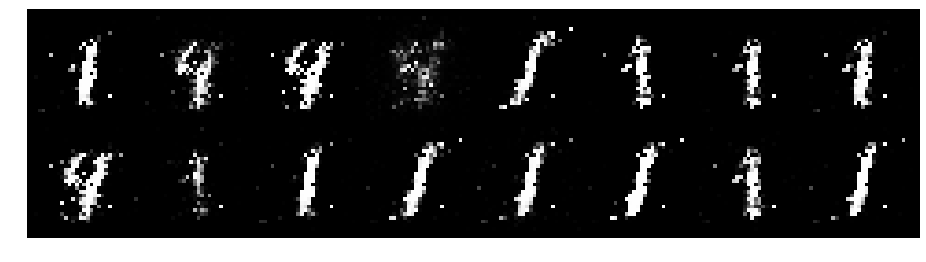

Epoch: [3/200], Batch Num: [0/600]
Discriminator Loss: 0.6724, Generator Loss: 5.0728
D(x): 0.9519, D(G(z)): 0.3798


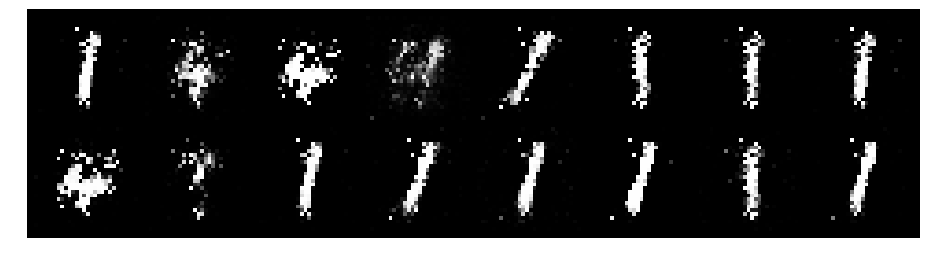

Epoch: [3/200], Batch Num: [100/600]
Discriminator Loss: 0.4210, Generator Loss: 3.8930
D(x): 0.9509, D(G(z)): 0.2268


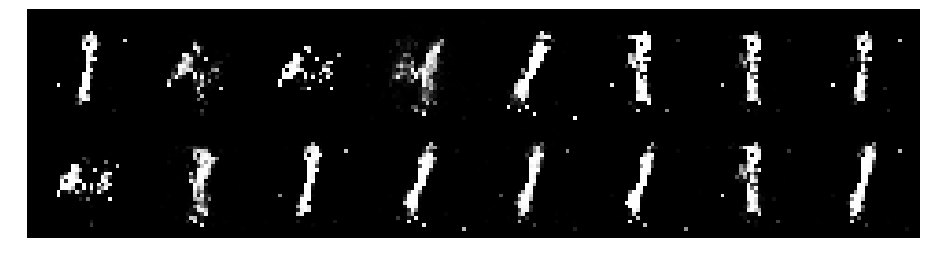

Epoch: [3/200], Batch Num: [200/600]
Discriminator Loss: 0.7401, Generator Loss: 4.6822
D(x): 0.9670, D(G(z)): 0.4056


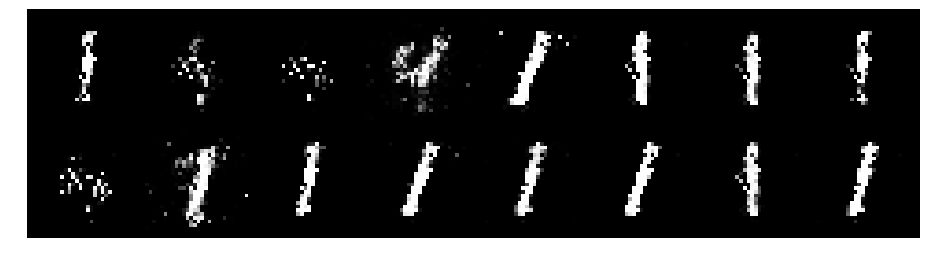

Epoch: [3/200], Batch Num: [300/600]
Discriminator Loss: 0.1985, Generator Loss: 3.1420
D(x): 0.9385, D(G(z)): 0.0751


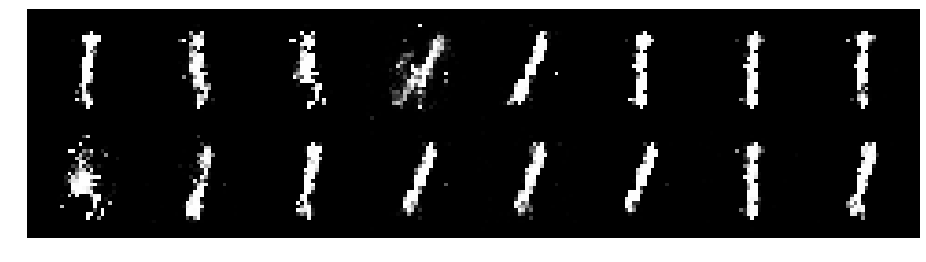

Epoch: [3/200], Batch Num: [400/600]
Discriminator Loss: 0.4013, Generator Loss: 2.4067
D(x): 0.8691, D(G(z)): 0.1037


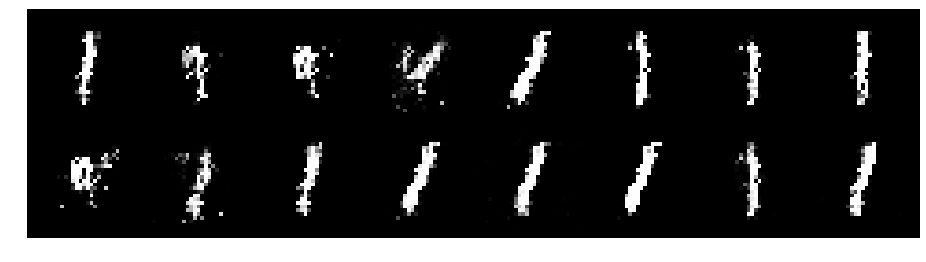

Epoch: [3/200], Batch Num: [500/600]
Discriminator Loss: 0.2539, Generator Loss: 3.2131
D(x): 0.9135, D(G(z)): 0.0656


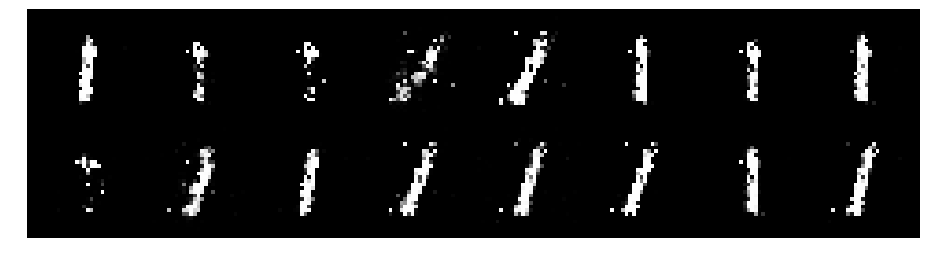

Epoch: [4/200], Batch Num: [0/600]
Discriminator Loss: 0.2967, Generator Loss: 2.9552
D(x): 0.9345, D(G(z)): 0.1425


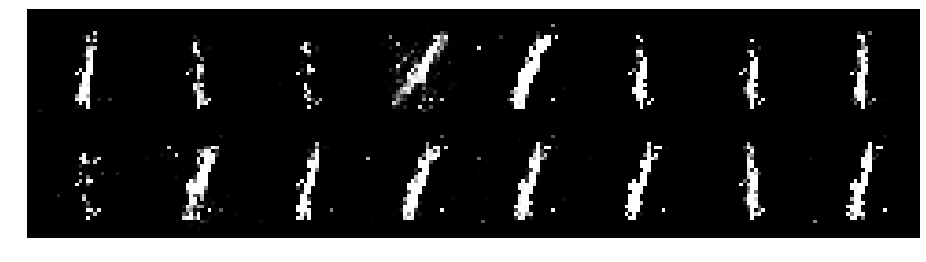

Epoch: [4/200], Batch Num: [100/600]
Discriminator Loss: 0.3016, Generator Loss: 2.4312
D(x): 0.9004, D(G(z)): 0.0887


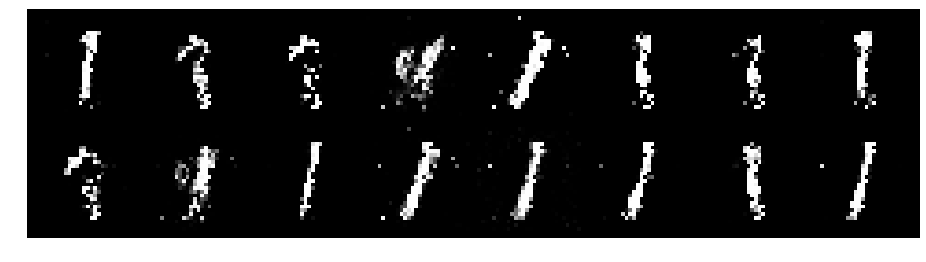

Epoch: [4/200], Batch Num: [200/600]
Discriminator Loss: 0.4825, Generator Loss: 2.3371
D(x): 0.8585, D(G(z)): 0.1674


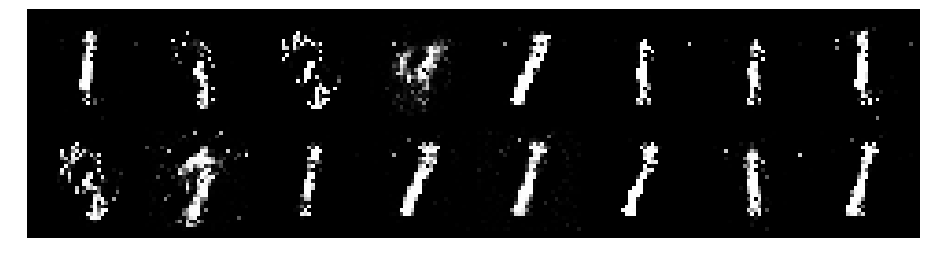

Epoch: [4/200], Batch Num: [300/600]
Discriminator Loss: 0.3386, Generator Loss: 2.0007
D(x): 0.8856, D(G(z)): 0.1134


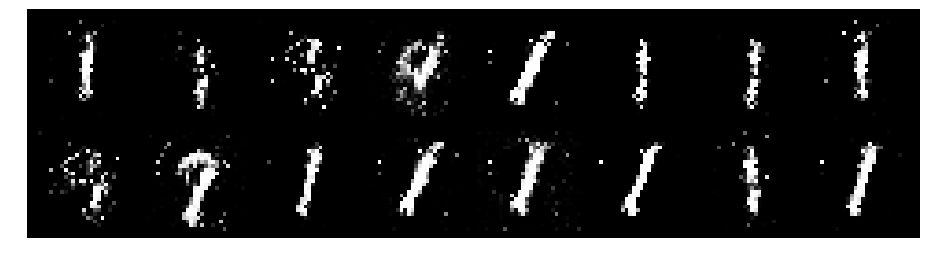

Epoch: [4/200], Batch Num: [400/600]
Discriminator Loss: 0.3808, Generator Loss: 2.4972
D(x): 0.8840, D(G(z)): 0.1345


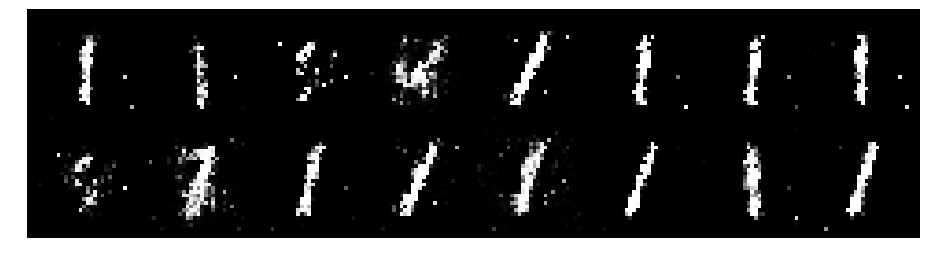

Epoch: [4/200], Batch Num: [500/600]
Discriminator Loss: 0.4204, Generator Loss: 1.9970
D(x): 0.8529, D(G(z)): 0.1015


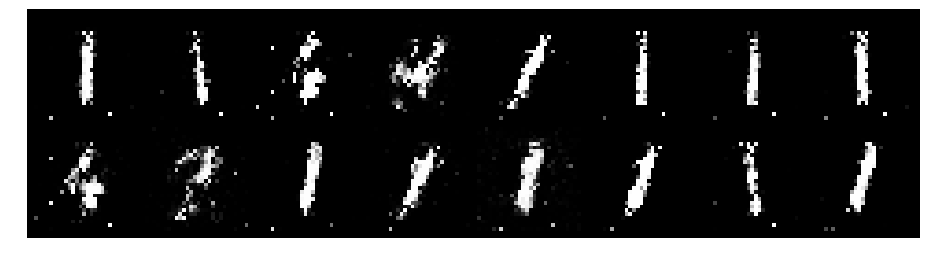

Epoch: [5/200], Batch Num: [0/600]
Discriminator Loss: 0.5126, Generator Loss: 3.3003
D(x): 0.9134, D(G(z)): 0.2863


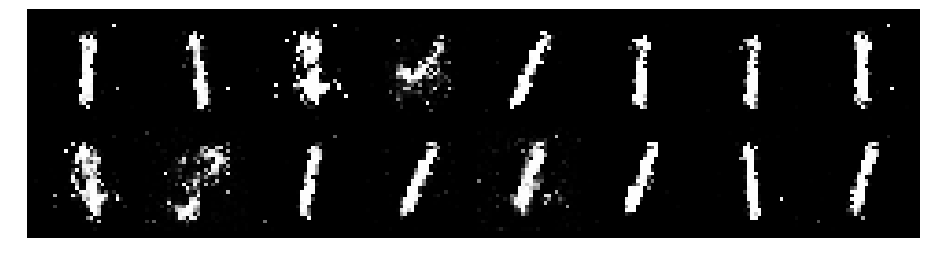

Epoch: [5/200], Batch Num: [100/600]
Discriminator Loss: 0.3958, Generator Loss: 2.7010
D(x): 0.8818, D(G(z)): 0.1393


KeyboardInterrupt: ignored

In [56]:
# Create logger instance
logger = Logger(model_name='VGAN', data_name='MNIST')
# Total number of epochs to train
num_epochs = 200
for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.size(0)
        
        
        # 1. Train Discreminator
        real_data = Variable(images_to_vectors(real_batch))
        # Generate fake data and detach  (so gradients are not calculated for generator)
        fake_data = G(noise(N)).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(D_optimizer, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = G(noise(N))
        # Train G
        g_error = train_generator(G_optimizer, fake_data)
        
        
        # Log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        # Display Progress every few batches
        if (n_batch) % 100 == 0: 
            test_images = vectors_to_images(G(test_noise))
            test_images = test_images.data
            logger.log_images(
                test_images, num_test_samples, 
                epoch, n_batch, num_batches
            );
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
